In [3]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from adjustText import adjust_text # install with pip install adjustText

## Settings

In [193]:
# settings
score_data_path = '../gallus_gallus_analysis/5_score_result/chicken_score_geneID.csv'
geneID2geneSymbol_data_path = './chicken_geneId2geneSym.txt'
gene2ensembl_data_path = './gene2ensembl.tsv'
gene2pubmed_data_path = './gene2pubmed.tsv'
tax_id = 9031 # 9823: pig, 9031: chicken

## Convert Ensembl geneID to NCBI geneID

In [194]:
# Read the Score data
df = pl.read_csv(score_data_path, columns=['GeneID', 'HN1.5'])

In [195]:
# Read the geneID2geneSymbol data
df_geneID2geneSymbol = pl.read_csv(geneID2geneSymbol_data_path, separator='\t')

In [196]:
# Read the gene2ensebml data
df_gene2ensembl = pl.read_csv(gene2ensembl_data_path, separator='\t')
df_gene2ensembl = (
	df_gene2ensembl
	.select(pl.col('#tax_id'), pl.col('GeneID'), pl.col('Ensembl_gene_identifier'))
	.filter(pl.col('#tax_id') == tax_id)
)

In [197]:
# Merge the data by ensembl gene ID
df_merged = (
	df
	.join(df_gene2ensembl, left_on='GeneID', right_on='Ensembl_gene_identifier', how='left')
	.rename({'GeneID': 'Ensembl_geneID'})
)

In [198]:
df_merged = (
	df_merged
	.join(df_geneID2geneSymbol, left_on='Ensembl_geneID', right_on='Gene_stable_ID', how='left')
)

In [199]:
# Select sort rename the data
df_selected = (
	df_merged
	.sort(by='HN1.5', descending=True)
	.rename({'GeneID_right': 'NCBIGeneID'})
)

## Count how well gene has benn studied

In [200]:
# Read the gene2pubmed data
df_gene2pubmed = pl.read_csv(gene2pubmed_data_path, separator='\t')
df_gene2pubmed_selected = df_gene2pubmed.filter(pl.col('#tax_id') == tax_id)

In [202]:
# Count how well gene has been studied and make the data table
df_counted_data = (
	df_gene2pubmed_selected
	.group_by('GeneID')
	.agg(pl.count('PubMed_ID').alias('Count'), pl.col('PubMed_ID').alias('Paper'))
)

# convert list to string
# remove csv export for list column - not supported by polars
# https://github.com/pola-rs/polars/issues/6038
df_counted_data = (
	df_counted_data
	.map_rows(lambda t: (t[0], t[1], str(t[2])))
	.rename({'column_0': 'GeneID', 'column_1': 'Count', 'column_2': 'Paper'})
)
df_counted_data

GeneID,Count,Paper
i64,i64,str
396256,13,"""[3487468, 3666…"
428652,2,"""[22301074, 300…"
100529683,1,"""[20149241]"""
100316006,3,"""[16381832, 184…"
124417393,2,"""[22301074, 300…"
419083,2,"""[22301074, 300…"
100884257,1,"""[20496162]"""
422608,6,"""[12445392, 156…"
424189,5,"""[12445392, 156…"


In [182]:
# ----------merge the data----------
df_result_analysis = (
	df_selected
	.join(df_counted_data, left_on='NCBIGeneID', right_on='GeneID', how='left')
	.drop('#tax_id')
    .unique(subset=['Ensembl_geneID'], maintain_order=True)
)
df_result_analysis.head(10)

Ensembl_geneID,HN1.5,NCBIGeneID,Gene_name,Count,Paper
str,i64,i64,str,i64,str
"""ENSGALG0001001…",36,423581,"""GNG2""",3,"""[15642098, 223…"
"""ENSGALG0001002…",34,424532,"""SSX2IP""",1,"""[16539694]"""
"""ENSGALG0001000…",32,421972,"""ATAD2B""",2,"""[22301074, 300…"
"""ENSGALG0001001…",31,420227,"""KIAA1429""",2,"""[30032202, 320…"
"""ENSGALG0001001…",31,422249,"""TM9SF2L""",3,"""[15642098, 223…"
"""ENSGALG0001002…",31,415320,"""HEXA""",3,"""[15642098, 223…"
"""ENSGALG0001002…",31,107049249,"""CD63""",2,"""[22301074, 300…"
"""ENSGALG0001000…",30,101748499,"""MHCY2B1""",2,"""[22301074, 300…"
"""ENSGALG0001000…",30,422667,"""BBS12""",2,"""[22301074, 300…"


## Plot the data

In [183]:

# add gene symbol
df_filtered = df_result_analysis.with_columns(
    pl.when(pl.col("Gene_name").is_null())
    .then(pl.col("Ensembl_geneID"))
    .otherwise(pl.col("Gene_name"))
    .alias("label")
)

In [184]:
df_filtered = df_filtered.with_columns(
    pl.col('Count').fill_null(0)
)
df_filtered

Ensembl_geneID,HN1.5,NCBIGeneID,Gene_name,Count,Paper,label
str,i64,i64,str,i64,str,str
"""ENSGALG0001001…",36,423581,"""GNG2""",3,"""[15642098, 223…","""GNG2"""
"""ENSGALG0001002…",34,424532,"""SSX2IP""",1,"""[16539694]""","""SSX2IP"""
"""ENSGALG0001000…",32,421972,"""ATAD2B""",2,"""[22301074, 300…","""ATAD2B"""
"""ENSGALG0001001…",31,420227,"""KIAA1429""",2,"""[30032202, 320…","""KIAA1429"""
"""ENSGALG0001001…",31,422249,"""TM9SF2L""",3,"""[15642098, 223…","""TM9SF2L"""
"""ENSGALG0001002…",31,415320,"""HEXA""",3,"""[15642098, 223…","""HEXA"""
"""ENSGALG0001002…",31,107049249,"""CD63""",2,"""[22301074, 300…","""CD63"""
"""ENSGALG0001000…",30,101748499,"""MHCY2B1""",2,"""[22301074, 300…","""MHCY2B1"""
"""ENSGALG0001000…",30,422667,"""BBS12""",2,"""[22301074, 300…","""BBS12"""


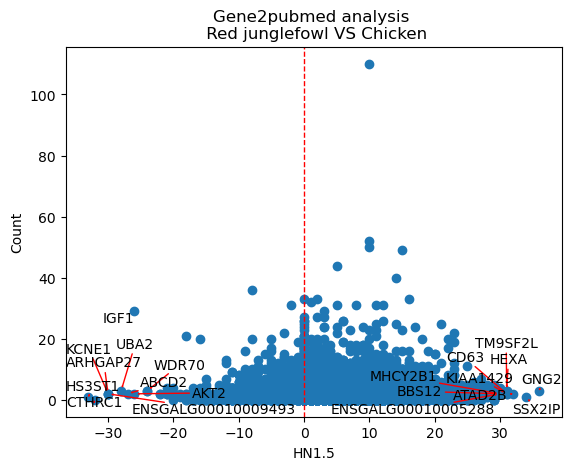

In [185]:
# 散布図をプロット
plt.scatter(df_filtered['HN1.5'], df_filtered['Count'])
plt.xlabel('HN1.5')
plt.ylabel('Count')
plt.title('Gene2pubmed analysis \n Red junglefowl VS Chicken')
plt.axvline(x=0, color='red', linewidth=1, linestyle='--')
# 上位20件と下位20件を取得
top_20 = df_filtered.sort(by='HN1.5', descending=True).head(10)
bottom_20 = df_filtered.sort(by='HN1.5', descending=False).head(10)
# ラベルを追加
texts = []
for df in [top_20, bottom_20]:
    for label, x, y in zip(df['label'], df['HN1.5'], df['Count']):
        texts.append(plt.text(x, y, label))
# ラベルが重ならないように調整
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

In [192]:
df_filtered.write_csv('./results/Chicken_gene2pubmed_analysis.tsv', separator='\t')